In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import pickle

In [2]:
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
def integrate_polynomial(p, a, b):
    """ 
    Calculate the exact integral of a polynomial p over bounds (a,b)
    The polynomial is given by a coefficient vector, as in:
    [3,2,1] -> 3 + 2x + x³
    """
    t_integrals = np.array([(1/(i+1)) * (b**(i+1) - a**(i+1))
                            for i in range(len(p))])
    return sum(p * t_integrals)
       
    
p = np.array([ 0, 1, 0, 0, -1 ])
assert integrate_polynomial(p, 0, 1) == 0.3

 # Gauss-Christoffel-Quadratur


## Legendre-Polynome Berechnen

In [4]:
t_pow = lambda i: np.append(np.zeros(i), 1)  # returns t**i as polynomial 

def add_polynomials(p1, p2):
    """
    Calculate the sum of two polynomials given by coefficient vectors
    i.e. for p(x) = 3 + 2x + x³:
    coefficients = [3,2,1]
    The order (desceding or ascending exponent) doesnt matter,
    but must be the same for both input polynomials.
    """
    p3 = np.zeros(max([len(p1), len(p2)]))
    for i, coeff in enumerate(p1):
        p3[i] += coeff
    for i,coeff in enumerate(p2):
        p3[i] += coeff
    return p3



"""
Calculate Legendre-Polynomials through Gram-Schmidt-Orthogonalisation
"""
def legendre_polynomials(N = 10):
    #A1
    legendre = [np.array([1.0])]
    for i in range(1,N):
        alpha_i = []
        #A2
        sum_alpha_p = np.array([0])
        for j in range(0,i):
            alpha_i.append(integrate_polynomial(np.convolve(t_pow(i), legendre[j]), -1.0, 1.0))
            print("alpha{}{} = {}".format(i,j,integrate_polynomial(np.convolve(t_pow(i), legendre[j]), -1.0, 1.0)))
            sum_alpha_p = add_polynomials(sum_alpha_p, alpha_i[j] * legendre[j])
        # A3
        print("p_star = {} - {}".format(t_pow(i),sum_alpha_p))
        p_star = add_polynomials(t_pow(i), -1*sum_alpha_p)
        # A4
        norm_p_star = np.sqrt(integrate_polynomial(np.convolve(p_star, p_star), -1.0, 1.0))
        p = p_star #/ norm_p_star
        legendre.append(p)
        print("legendre {} = {}".format(i,p))
    return legendre
        #A5

In [5]:
legendre = legendre_polynomials(3)

alpha10 = 0.0
p_star = [0. 1.] - [0.]
legendre 1 = [0. 1.]
alpha20 = 0.6666666666666666
alpha21 = 0.0
p_star = [0. 0. 1.] - [0.66666667 0.        ]
legendre 2 = [-0.66666667  0.          1.        ]


In [6]:
from scipy.special import legendre as scp_legendre
for n,p in enumerate(legendre):
    print("Soll: " + str(list(reversed(scp_legendre(n).coefficients))))
    print("Ist : " + str(p))

Soll: [1.0]
Ist : [1.]
Soll: [0.0, 1.0]
Ist : [0. 1.]
Soll: [-0.5, 0.0, 1.5]
Ist : [-0.66666667  0.          1.        ]


In [7]:
### ersteze berechnete Legendre-Polynome durch welche von scipy.special.legendre
legendre = lambda n: np.array(list(scp_legendre(n).coefficients))

## Stützstellen als Nullstellen der Legendre-Polynome

### Transformation

In [8]:
def transform_gausspts(pts, a = -1.0,b=1.0):
    return np.array([(b-a)/2*x + (a+b)/2 for x in pts])

print("Stützstellen auf Referenzintervall [-1,1]:")
for n in range(4):
    print(np.roots(legendre(n+1)))
    
print("Stützstellen auf Referenzinterval [0,1]")
for n in range(4):
    print(transform_gausspts(sorted(np.roots(legendre(n+1))),0,1))

Stützstellen auf Referenzintervall [-1,1]:
[0.]
[-0.57735027  0.57735027]
[-0.77459667  0.77459667  0.        ]
[ 0.86113631 -0.86113631  0.33998104 -0.33998104]
Stützstellen auf Referenzinterval [0,1]
[0.5]
[0.21132487 0.78867513]
[0.11270167 0.5        0.88729833]
[0.06943184 0.33000948 0.66999052 0.93056816]


### Speichern

In [9]:
MAX_PTS = 10
# auf -1,1
lambdas = {n+1: sorted(np.roots(legendre(n+1))) for n in range(MAX_PTS+1)}
# auf 0,1
lambdas = {n: transform_gausspts(l,0,1) for n,l in lambdas.items()}
save_obj(lambdas, "testat2_tau")
# to load: load_obj("testat2_tau")

## Gewichte (Lagrange)

### Berechnen

In [10]:
def gauss_weights(gausspts, t_min = -1.0, t_max = 1.0):
    """
    Given an array of gauss points,
    calculate an array of Gauss weights
    on the reference interval [t_min,t_max]
    """
 
    npts = len(gausspts)
    coeffs = np.zeros(npts)

    for i in range(npts):

        ti = gausspts[i]

        prod = np.array([1])
        for j in range(npts):
            if not i == j:
                tj = gausspts[j]
                a = 1/(ti - tj)
                p_ = a * np.array([-tj, 1]) # a*(t-t_j)
                prod = np.convolve(prod, p_)  # polynomial multiplication
        c = integrate_polynomial(prod, t_min, t_max) 
        assert c > 0, "Weights must be > 0"
        coeffs[i] = c
    return coeffs

### Speichern

In [11]:
tau = load_obj("testat2_tau")

all_weights = {}
for n in range(1,max(tau.keys())):
    all_weights[n] = gauss_weights(gausspts = tau[n],t_min=0.0,t_max=1.0)
save_obj(all_weights, "testat2_lambda")    

## Quadraturfunktion Gauss

In [12]:
def quad_Gauss(f, a, b, N):
    """
    Approximate the integral of any (callable) function f
    on the interval a,b
    using Gauss Quadrature with N support points.
    Weights/support points are loaded for the reference interval [0,1]
    and must be transformed to the integration interval.
    """
    try:
        weights = load_obj("testat2_lambda")[N]
    except KeyError as e:
        print("Weights for N={} not available".format(N))
        return
    
    try:
        support_points = load_obj("testat2_tau")[N]
    except KeyError as e:
        print("Gausspts for N={} not available".format(N))
        return
    
    # transform support points to [a,b] to get function values
    support_points = [a + (b-a)*t for t in support_points]
    function_values = [f(t) for t in support_points]
    
    #print("weights: \t {}".format(weights))
    #print("supports: \t {}".format(support_points))
    #print("function: \t {}".format(function_values))
    
    return (b-a) * sum(weights*function_values)

# Newton-Cotes
## Quadraturfunction NC (Gewichte werden geladen)

In [13]:
def quad_NC(f, a, b, N):
    """
    Approximate the integral of any (callable) function f
    on the interval a,b
    using Newton-Cotes Quadrature with N support points.
    The weights are loaded for the reference interval [0,1]
    and must be transformed to the function interval.
    """
    try:
        weights = load_obj("ub8_nc_weights")[N]
    except KeyError as e:
        print("Weights for N={} not available".format(N))
        return
    weights = weights[:N]  # only the first N, rest are 0
    support_points = np.linspace(a,b,N)
    
    function_values = [f(ti) for ti in support_points]
    
    return (b-a) * sum(weights*function_values)

# Integration
## Definitionen

In [14]:
omega = 13.6753
PI    = np.arccos(-1)
Tmin  = 0.0
Tmax  = 0.5*np.pi

def f(t): 
    return np.sin(omega*t)

## Plot function and integration points

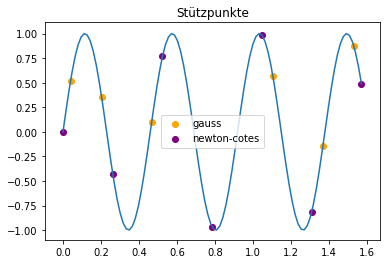

In [15]:
N = 7  # anzahl Stüzstellen für Plot

# Newton-Cotes Stützpunkte
tau_NC = np.linspace(Tmin,Tmax,N)

# Gauss Stützpunkte
tau = load_obj("testat2_tau")
tau_G = tau[N]
tau_G = Tmin + (Tmax - Tmin)*tau_G # transformation

T = np.linspace(Tmin, Tmax, 100)
plt.plot(T, f(T))
plt.scatter(tau_G,f(tau_G),label='gauss',color='orange')
plt.scatter(tau_NC,f(tau_NC),label='newton-cotes',color='purple')
plt.title("Stützpunkte")
plt.legend()
plt.show()

## Exates Integral

"Exact" -> scipy's quad function.

$
\int_{t=0}^{\pi/2} f(t) dt = \int_{t=0}^{\pi/2} sin (wt) dt =
$

In [16]:
from scipy import integrate
result, errorbound = integrate.quad(f, Tmin, Tmax)
print("result = {}".format(result))
print("max error = {}".format(errorbound))

I_ex = result

result = 0.13694223655230858
max error = 6.026545148335449e-12


## Approximiertes Integral

In [17]:
quadfunc = quad_NC
print("Newton-Cotes:")
for n in range(2,8):
    I = quadfunc(f, Tmin, Tmax, n)
    e = abs(I_ex - I)
    print("o={}, I={} \t Fehler = {}".format(n, I, e))

quadfunc = quad_Gauss
print("Gauss-Christoffel:")
for n in range(1,11):
    I = quadfunc(f, Tmin, Tmax, n)
    e = abs(I_ex - I)
    print("o={}, I={} \t Fehler = {}".format(n, I, e))

Newton-Cotes:
o=2, I=0.38343926342917667 	 Fehler = 0.24649702687686809
o=3, I=-0.8855165839223643 	 Fehler = 1.022458820474673
o=4, I=1.1279553948515686 	 Fehler = 0.9910131582992601
o=5, I=-0.803924390927535 	 Fehler = 0.9408666274798436
o=6, I=-0.44276678415863785 	 Fehler = 0.5797090207109464
o=7, I=-0.8660547701464941 	 Fehler = 1.0029970066988028
Gauss-Christoffel:
o=1, I=-1.5199945075981345 	 Fehler = 1.656936744150443
o=2, I=-1.5148718618357326 	 Fehler = 1.6518140983880412
o=3, I=-0.29642079887855327 	 Fehler = 0.43336303543086185
o=4, I=1.385715363716855 	 Fehler = 1.2487731271645466
o=5, I=-0.7277322732999928 	 Fehler = 0.8646745098523014
o=6, I=0.4370722347045538 	 Fehler = 0.3001299981522452
o=7, I=0.0714919237498817 	 Fehler = 0.06545031280242689
o=8, I=0.14690429874386962 	 Fehler = 0.009962062191561039
o=9, I=0.13581468201915053 	 Fehler = 0.0011275545331580483
o=10, I=0.13704131124035962 	 Fehler = 9.907468805103736e-05


# e) Unterteilte Integration

In [28]:
M = 7 # Anzahl Abschnitte
N = 7 # Anzahl Stützstellen

parts = np.linspace(Tmin,Tmax,M+1)

I = 0
for m in range(M):
    start = parts[m]
    end = parts[m+1]
    I +=  quad_Gauss(f, start, end, N)
    
print("{} Abschnitte, {} Stützstellen:".format(M,N))
print("I = {}".format(I))
print("e = {}".format(abs(I_ex - I)))

7 Abschnitte, 7 Stützstellen:
I = 0.13694223655242854
e = 1.1995959781074816e-13
